### Загрузка данных

In [1]:
import pandas as pd

# чтение файлов
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')

# отбросим столбец id
train_df.drop(["id"], axis=1, inplace=True)
train_df.head()

,rko_start_months,max_end_fact_fin_deals,max_end_plan_non_fin_deals,max_start_fin_deals,max_start_non_fin_deals,min_end_fact_fin_deals,min_end_plan_non_fin_deals,min_start_fin_deals,min_start_non_fin_deals,balance_amt_avg,...,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,target_1,target_2,total_target
0,-1.279132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.495465,...,0.352516,-0.081310,0.210189,1.140808,0.647477,0.810887,1.909568,0,0,0
1,-1.142591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.441660,...,-0.188287,-0.650616,-0.316563,-1.136536,-0.127326,-0.147319,-0.517805,0,0,0
2,1.812270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.721481,...,-0.323487,0.632731,2.541558,3.017482,0.033394,0.019972,0.578428,0,0,0
3,-0.479407,NaN,0.356677,NaN,-0.332867,NaN,-0.704164,NaN,0.905748,-0.825400,...,-0.323487,-0.003549,-0.219016,0.228624,-0.428185,-0.220932,-0.596108,0,0,0
4,-1.503690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.220356,...,-0.323487,0.182726,-0.287299,-0.528921,-0.563335,-0.021506,-0.361201,0,0,0


## Обработка данных

### Обработка категориальных признаков

In [2]:
cat_cols = [
    'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment'
]
# закодируем категориальные признаки

from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()

for col in cat_cols:
    label_encoder.fit(train_df[col])
    train_df[col] = label_encoder.transform(train_df[col])

### Обработка пустых значений

In [3]:
# найдем строки с пустыми значениями
train_nans = train_df.isna().sum().sort_values(ascending=False)
train_nans

max_end_plan_non_fin_deals    287521
min_end_plan_non_fin_deals    287521
max_start_non_fin_deals       287515
min_start_non_fin_deals       287515
max_end_fact_fin_deals        263086
                               ...  
sum_deb_e_oper_1m                  0
sum_cred_e_oper_3m                 0
sum_cred_d_oper_1m                 0
sum_deb_d_oper_1m                  0
total_target                       0
Length: 102, dtype: int64

### Признаки с малым кол-вом пропусков заменяем медианой или наиболее часто встречающимся значением

In [4]:
# в обучающих данных
train_nans = train_nans.loc[lambda x: x > 0]
smaller_train_nans = train_nans[10:]

for i in smaller_train_nans.index:
    if train_df[i].dtype == "object":
        train_df[i].loc[train_df[i].isna()] = train_df[i].value_counts().sort_values(ascending=False).index[0]
    else:
        train_df[i].loc[train_df[i].isna()] = train_df[i].median()


# в тестовых данных
test_nans = test_df.isna().sum().sort_values(ascending=False).loc[lambda x: x > 0]

smaller_test_nans = test_nans[10:]

for i in smaller_test_nans.index:
    if test_df[i].dtype == "object":
        test_df[i].loc[test_df[i].isna()] = test_df[i].value_counts().sort_values(ascending=False).index[0]
    else:
        test_df[i].loc[test_df[i].isna()] = test_df[i].median()

test_nans = test_df.isna().sum().sort_values(ascending=False)

C:\Users\serpr\AppData\Local\Temp\ipykernel_5064\2413672272.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[i].loc[train_df[i].isna()] = train_df[i].median()
C:\Users\serpr\AppData\Local\Temp\ipykernel_5064\2413672272.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[i].loc[train_df[i].isna()] = train_df[i].median()
C:\Users\serpr\AppData\Local\Temp\ipykernel_5064\2413672272.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

### Признаки с большим количеством пропусков
Первые топ-10 признаков по пропускам:

max_end_plan_non_fin_deals: Кол-во месяцев до максимальной плановой даты закрытия среди текущих сделок по всем срочным продуктам
min_end_plan_non_fin_deals: Кол-во месяцев до минимальной плановой даты закрытия среди текущих сделок по всем срочным продуктам
min_start_non_fin_deals: Кол-во месяцев до минимальной даты открытия среди текущих сделок по всем срочным продуктам
max_start_non_fin_deals: Кол-во месяцев до максимальной даты закрытия среди текущих сделок по всем срочным продуктам

max_end_fact_fin_deals: Кол-во месяцев до максимальной фактической даты закрытия среди закрытых сделок по всем срочным продуктам
max_start_fin_deals: Кол-во месяцев до максимальной даты закрытия среди закрытых сделок по всем срочным продуктам
min_end_fact_fin_deals: Кол-во месяцев до минимальной фактической даты закрытия среди закрытых сделок по всем срочным продуктам
min_start_fin_deals: Кол-во месяцев до минимальной даты открытия среди закрытых сделок по всем срочным продуктам

max_founderpres: Количество дней, прошедших с первой даты регистрации огрн
min_founderpres: Количество дней, прошедших с последней даты регистрации огрн

Заметим, что в этих признаках процент пропусков составляет от 86-93%
Поэтому просто отбросим эти признаки, а признак регистрации ОГРН сделаем бинарным - зарегестрировано/незарегистрированно


In [5]:
train_df.drop(["max_end_plan_non_fin_deals",
               "min_end_plan_non_fin_deals",
               "max_start_non_fin_deals",
               "min_start_non_fin_deals",
               "max_end_fact_fin_deals",
               "max_start_fin_deals",
               "min_end_fact_fin_deals",
               "min_start_fin_deals",
               ], axis=1, inplace=True)

test_df.drop(["max_end_plan_non_fin_deals",
              "min_end_plan_non_fin_deals",
              "max_start_non_fin_deals",
              "min_start_non_fin_deals",
              "max_end_fact_fin_deals",
              "max_start_fin_deals",
              "min_end_fact_fin_deals",
              "min_start_fin_deals",
              ], axis=1, inplace=True)

In [6]:
train_df.isna().sum().sort_values(ascending=False)

min_founderpres           175817
max_founderpres           175817
rko_start_months               0
sum_c_oper_3m                  0
cnt_days_deb_e_oper_3m         0
                           ...  
cnt_deb_d_oper_1m              0
sum_deb_d_oper_1m              0
cnt_c_oper_1m                  0
sum_c_oper_1m                  0
total_target                   0
Length: 94, dtype: int64

### Конструирование новых признаков, удаление ненужных признаков

Если значение min(max)_founderpres - NaN значит человек не регистрировал себе ОГРН, иначе регистрировал.

In [7]:
train_df["ogrn_reg"] = (train_df["max_founderpres"].isna()*1 - 1) * -1
train_df[["ogrn_reg", "max_founderpres"]]

,ogrn_reg,max_founderpres
0,1,-0.963860
1,0,NaN
2,1,-0.271164
3,0,NaN
4,0,NaN
...,...,...
299995,1,-0.754824
299996,1,0.549400
299997,0,NaN
299998,0,NaN


In [8]:
# удалим старые признаки
train_df.drop(["max_founderpres", "min_founderpres"], axis=1, inplace=True)

Проделаем тоже самое для тестовых данных

In [9]:
test_df["ogrn_reg"] = (test_df["max_founderpres"].isna()*1 - 1) * -1
test_df.drop(["max_founderpres", "min_founderpres"], axis=1, inplace=True)

train_df["ogrn_reg"] = train_df["ogrn_reg"].astype("category")
test_df["ogrn_reg"] = test_df["ogrn_reg"].astype("category")
# train_df[cat_indexes] = train_df[cat_indexes].astype("category")
# test_df[cat_indexes] = test_df[cat_indexes].astype("category")

Проверим, остались ли пропуски после обработки

In [10]:
train_df.isna().sum()

rko_start_months           0
balance_amt_avg            0
balance_amt_max            0
balance_amt_min            0
balance_amt_day_avg        0
                          ..
cnt_days_cred_h_oper_3m    0
target_1                   0
target_2                   0
total_target               0
ogrn_reg                   0
Length: 93, dtype: int64

In [11]:
test_df.isna().sum()

id                         0
rko_start_months           0
balance_amt_avg            0
balance_amt_max            0
balance_amt_min            0
                          ..
cnt_days_deb_h_oper_3m     0
sum_cred_h_oper_3m         0
cnt_cred_h_oper_3m         0
cnt_days_cred_h_oper_3m    0
ogrn_reg                   0
Length: 91, dtype: int64

В данных есть признак - index_city_code	код города в почтовом индексе. Так как мы закодировали города, можно избавиться от этого признака, он будет создавать лишние зависимости

In [12]:
train_df.drop(['index_city_code'], axis=1, inplace=True)

# повторим для тестовых данных
test_df.drop(['index_city_code'], axis=1, inplace=True)

Заметим, что в наших данных есть такие признаки как sum_a_oper_1m и cnt_a_oper_1m - сумма операций типа А за месяц и их количество. Это распространяется и на другие типы операций. Сконструируем новый признак sum/cnt - средняя сумма операции типа A в месяц. Распространим эту логику на все типы операций.

In [13]:
# для операций типа A, B, C
train_df['med_sum_oper_a_1m'] = train_df['sum_a_oper_1m']/train_df['cnt_a_oper_1m']
train_df.drop(['sum_a_oper_1m', 'cnt_a_oper_1m'], axis=1, inplace=True)

train_df['med_sum_oper_b_1m'] = train_df['sum_b_oper_1m']/train_df['cnt_b_oper_1m']
train_df.drop(['sum_b_oper_1m', 'cnt_b_oper_1m'], axis=1, inplace=True)

train_df['med_sum_oper_c_1m'] = train_df['sum_c_oper_1m']/train_df['cnt_c_oper_1m']
train_df.drop(['sum_c_oper_1m', 'cnt_c_oper_1m'], axis=1, inplace=True)

In [14]:
# для исходящих операций типа D, E, F, G, H
train_df['med_sum_deb_d_oper_1m'] = train_df['sum_deb_d_oper_1m']/train_df['cnt_deb_d_oper_1m']
train_df.drop(['sum_deb_d_oper_1m', 'cnt_deb_d_oper_1m'], axis=1, inplace=True)

train_df['med_sum_deb_e_oper_1m'] = train_df['sum_deb_e_oper_1m']/train_df['cnt_deb_e_oper_1m']
train_df.drop(['sum_deb_e_oper_1m', 'cnt_deb_e_oper_1m'], axis=1, inplace=True)

train_df['med_sum_deb_f_oper_1m'] = train_df['sum_deb_f_oper_1m']/train_df['cnt_deb_f_oper_1m']
train_df.drop(['sum_deb_f_oper_1m', 'cnt_deb_f_oper_1m'], axis=1, inplace=True)

train_df['med_sum_deb_g_oper_1m'] = train_df['sum_deb_g_oper_1m']/train_df['cnt_deb_g_oper_1m']
train_df.drop(['sum_deb_g_oper_1m', 'cnt_deb_g_oper_1m'], axis=1, inplace=True)

train_df['med_sum_deb_h_oper_1m'] = train_df['sum_deb_h_oper_1m']/train_df['cnt_deb_h_oper_1m']
train_df.drop(['sum_deb_h_oper_1m', 'cnt_deb_h_oper_1m'], axis=1, inplace=True)

# для входящих операций типа D, E, F, G, H
train_df['med_sum_cred_d_oper_1m'] = train_df['sum_cred_d_oper_1m']/train_df['cnt_cred_d_oper_1m']
train_df.drop(['sum_cred_d_oper_1m', 'cnt_cred_d_oper_1m'], axis=1, inplace=True)

train_df['med_sum_cred_e_oper_1m'] = train_df['sum_cred_e_oper_1m']/train_df['cnt_cred_e_oper_1m']
train_df.drop(['sum_cred_e_oper_1m', 'cnt_cred_e_oper_1m'], axis=1, inplace=True)

train_df['med_sum_cred_f_oper_1m'] = train_df['sum_cred_f_oper_1m']/train_df['cnt_cred_f_oper_1m']
train_df.drop(['sum_cred_f_oper_1m', 'cnt_cred_f_oper_1m'], axis=1, inplace=True)

train_df['med_sum_cred_g_oper_1m'] = train_df['sum_cred_g_oper_1m']/train_df['cnt_cred_g_oper_1m']
train_df.drop(['sum_cred_g_oper_1m', 'cnt_cred_g_oper_1m'], axis=1, inplace=True)

train_df['med_sum_cred_h_oper_1m'] = train_df['sum_cred_h_oper_1m']/train_df['cnt_cred_h_oper_1m']
train_df.drop(['sum_cred_h_oper_1m', 'cnt_cred_h_oper_1m'], axis=1, inplace=True)

Аналогично заменим признаки суммы и количества операций разного типа для 3 месяцев

In [15]:
# для операций типа A, B, C
train_df['med_sum_oper_a_3m'] = train_df['sum_a_oper_3m']/train_df['cnt_a_oper_3m']
train_df.drop(['sum_a_oper_3m', 'cnt_a_oper_3m'], axis=1, inplace=True)

train_df['med_sum_oper_b_3m'] = train_df['sum_b_oper_3m']/train_df['cnt_b_oper_3m']
train_df.drop(['sum_b_oper_3m', 'cnt_b_oper_3m'], axis=1, inplace=True)

train_df['med_sum_oper_c_3m'] = train_df['sum_c_oper_3m']/train_df['cnt_c_oper_3m']
train_df.drop(['sum_c_oper_3m', 'cnt_c_oper_3m'], axis=1, inplace=True)

# для исходящих операций типа D, E, F, G, H
train_df['med_sum_deb_d_oper_3m'] = train_df['sum_deb_d_oper_3m']/train_df['cnt_deb_d_oper_3m']
train_df.drop(['sum_deb_d_oper_3m', 'cnt_deb_d_oper_3m'], axis=1, inplace=True)

train_df['med_sum_deb_e_oper_3m'] = train_df['sum_deb_e_oper_3m']/train_df['cnt_deb_e_oper_3m']
train_df.drop(['sum_deb_e_oper_3m', 'cnt_deb_e_oper_3m'], axis=1, inplace=True)

train_df['med_sum_deb_f_oper_3m'] = train_df['sum_deb_f_oper_3m']/train_df['cnt_deb_f_oper_3m']
train_df.drop(['sum_deb_f_oper_3m', 'cnt_deb_f_oper_3m'], axis=1, inplace=True)

train_df['med_sum_deb_g_oper_3m'] = train_df['sum_deb_g_oper_3m']/train_df['cnt_deb_g_oper_3m']
train_df.drop(['sum_deb_g_oper_3m', 'cnt_deb_g_oper_3m'], axis=1, inplace=True)

train_df['med_sum_deb_h_oper_3m'] = train_df['sum_deb_h_oper_3m']/train_df['cnt_deb_h_oper_3m']
train_df.drop(['sum_deb_h_oper_3m', 'cnt_deb_h_oper_3m'], axis=1, inplace=True)

# для входящих операций типа D, E, F, G, H
train_df['med_sum_cred_d_oper_3m'] = train_df['sum_cred_d_oper_3m']/train_df['cnt_cred_d_oper_3m']
train_df.drop(['sum_cred_d_oper_3m', 'cnt_cred_d_oper_3m'], axis=1, inplace=True)

train_df['med_sum_cred_e_oper_3m'] = train_df['sum_cred_e_oper_3m']/train_df['cnt_cred_e_oper_3m']
train_df.drop(['sum_cred_e_oper_3m', 'cnt_cred_e_oper_3m'], axis=1, inplace=True)

train_df['med_sum_cred_f_oper_3m'] = train_df['sum_cred_f_oper_3m']/train_df['cnt_cred_f_oper_3m']
train_df.drop(['sum_cred_f_oper_3m', 'cnt_cred_f_oper_3m'], axis=1, inplace=True)

train_df['med_sum_cred_g_oper_3m'] = train_df['sum_cred_g_oper_3m']/train_df['cnt_cred_g_oper_3m']
train_df.drop(['sum_cred_g_oper_3m', 'cnt_cred_g_oper_3m'], axis=1, inplace=True)

train_df['med_sum_cred_h_oper_3m'] = train_df['sum_cred_h_oper_3m']/train_df['cnt_cred_h_oper_3m']
train_df.drop(['sum_cred_h_oper_3m', 'cnt_cred_h_oper_3m'], axis=1, inplace=True)

In [16]:
# повторим для тестовых данных

# для операций типа A, B, C за 1 месяц
test_df['med_sum_oper_a_1m'] = test_df['sum_a_oper_1m']/test_df['cnt_a_oper_1m']
test_df.drop(['sum_a_oper_1m', 'cnt_a_oper_1m'], axis=1, inplace=True)

test_df['med_sum_oper_b_1m'] = test_df['sum_b_oper_1m']/test_df['cnt_b_oper_1m']
test_df.drop(['sum_b_oper_1m', 'cnt_b_oper_1m'], axis=1, inplace=True)

test_df['med_sum_oper_c_1m'] = test_df['sum_c_oper_1m']/test_df['cnt_c_oper_1m']
test_df.drop(['sum_c_oper_1m', 'cnt_c_oper_1m'], axis=1, inplace=True)

# для исходящих операций типа D, E, F, G, H за 1 месяц
test_df['med_sum_deb_d_oper_1m'] = test_df['sum_deb_d_oper_1m']/test_df['cnt_deb_d_oper_1m']
test_df.drop(['sum_deb_d_oper_1m', 'cnt_deb_d_oper_1m'], axis=1, inplace=True)

test_df['med_sum_deb_e_oper_1m'] = test_df['sum_deb_e_oper_1m']/test_df['cnt_deb_e_oper_1m']
test_df.drop(['sum_deb_e_oper_1m', 'cnt_deb_e_oper_1m'], axis=1, inplace=True)

test_df['med_sum_deb_f_oper_1m'] = test_df['sum_deb_f_oper_1m']/test_df['cnt_deb_f_oper_1m']
test_df.drop(['sum_deb_f_oper_1m', 'cnt_deb_f_oper_1m'], axis=1, inplace=True)

test_df['med_sum_deb_g_oper_1m'] = test_df['sum_deb_g_oper_1m']/test_df['cnt_deb_g_oper_1m']
test_df.drop(['sum_deb_g_oper_1m', 'cnt_deb_g_oper_1m'], axis=1, inplace=True)

test_df['med_sum_deb_h_oper_1m'] = test_df['sum_deb_h_oper_1m']/test_df['cnt_deb_h_oper_1m']
test_df.drop(['sum_deb_h_oper_1m', 'cnt_deb_h_oper_1m'], axis=1, inplace=True)

# для входящих операций типа D, E, F, G, H за 1 месяц
test_df['med_sum_cred_d_oper_1m'] = test_df['sum_cred_d_oper_1m']/test_df['cnt_cred_d_oper_1m']
test_df.drop(['sum_cred_d_oper_1m', 'cnt_cred_d_oper_1m'], axis=1, inplace=True)

test_df['med_sum_cred_e_oper_1m'] = test_df['sum_cred_e_oper_1m']/test_df['cnt_cred_e_oper_1m']
test_df.drop(['sum_cred_e_oper_1m', 'cnt_cred_e_oper_1m'], axis=1, inplace=True)

test_df['med_sum_cred_f_oper_1m'] = test_df['sum_cred_f_oper_1m']/test_df['cnt_cred_f_oper_1m']
test_df.drop(['sum_cred_f_oper_1m', 'cnt_cred_f_oper_1m'], axis=1, inplace=True)

test_df['med_sum_cred_g_oper_1m'] = test_df['sum_cred_g_oper_1m']/test_df['cnt_cred_g_oper_1m']
test_df.drop(['sum_cred_g_oper_1m', 'cnt_cred_g_oper_1m'], axis=1, inplace=True)

test_df['med_sum_cred_h_oper_1m'] = test_df['sum_cred_h_oper_1m']/test_df['cnt_cred_h_oper_1m']
test_df.drop(['sum_cred_h_oper_1m', 'cnt_cred_h_oper_1m'], axis=1, inplace=True)

# для операций типа A, B, C за 3 месяца
test_df['med_sum_oper_a_3m'] = test_df['sum_a_oper_3m']/test_df['cnt_a_oper_3m']
test_df.drop(['sum_a_oper_3m', 'cnt_a_oper_3m'], axis=1, inplace=True)

test_df['med_sum_oper_b_3m'] = test_df['sum_b_oper_3m']/test_df['cnt_b_oper_3m']
test_df.drop(['sum_b_oper_3m', 'cnt_b_oper_3m'], axis=1, inplace=True)

test_df['med_sum_oper_c_3m'] = test_df['sum_c_oper_3m']/test_df['cnt_c_oper_3m']
test_df.drop(['sum_c_oper_3m', 'cnt_c_oper_3m'], axis=1, inplace=True)

# для исходящих операций типа D, E, F, G, H за 3 месяца
test_df['med_sum_deb_d_oper_3m'] = test_df['sum_deb_d_oper_3m']/test_df['cnt_deb_d_oper_3m']
test_df.drop(['sum_deb_d_oper_3m', 'cnt_deb_d_oper_3m'], axis=1, inplace=True)

test_df['med_sum_deb_e_oper_3m'] = test_df['sum_deb_e_oper_3m']/test_df['cnt_deb_e_oper_3m']
test_df.drop(['sum_deb_e_oper_3m', 'cnt_deb_e_oper_3m'], axis=1, inplace=True)

test_df['med_sum_deb_f_oper_3m'] = test_df['sum_deb_f_oper_3m']/test_df['cnt_deb_f_oper_3m']
test_df.drop(['sum_deb_f_oper_3m', 'cnt_deb_f_oper_3m'], axis=1, inplace=True)

test_df['med_sum_deb_g_oper_3m'] = test_df['sum_deb_g_oper_3m']/test_df['cnt_deb_g_oper_3m']
test_df.drop(['sum_deb_g_oper_3m', 'cnt_deb_g_oper_3m'], axis=1, inplace=True)

test_df['med_sum_deb_h_oper_3m'] = test_df['sum_deb_h_oper_3m']/test_df['cnt_deb_h_oper_3m']
test_df.drop(['sum_deb_h_oper_3m', 'cnt_deb_h_oper_3m'], axis=1, inplace=True)

# для входящих операций типа D, E, F, G, H за 3 месяца
test_df['med_sum_cred_d_oper_3m'] = test_df['sum_cred_d_oper_3m']/test_df['cnt_cred_d_oper_3m']
test_df.drop(['sum_cred_d_oper_3m', 'cnt_cred_d_oper_3m'], axis=1, inplace=True)

test_df['med_sum_cred_e_oper_3m'] = test_df['sum_cred_e_oper_3m']/test_df['cnt_cred_e_oper_3m']
test_df.drop(['sum_cred_e_oper_3m', 'cnt_cred_e_oper_3m'], axis=1, inplace=True)

test_df['med_sum_cred_f_oper_3m'] = test_df['sum_cred_f_oper_3m']/test_df['cnt_cred_f_oper_3m']
test_df.drop(['sum_cred_f_oper_3m', 'cnt_cred_f_oper_3m'], axis=1, inplace=True)

test_df['med_sum_cred_g_oper_3m'] = test_df['sum_cred_g_oper_3m']/test_df['cnt_cred_g_oper_3m']
test_df.drop(['sum_cred_g_oper_3m', 'cnt_cred_g_oper_3m'], axis=1, inplace=True)

test_df['med_sum_cred_h_oper_3m'] = test_df['sum_cred_h_oper_3m']/test_df['cnt_cred_h_oper_3m']
test_df.drop(['sum_cred_h_oper_3m', 'cnt_cred_h_oper_3m'], axis=1, inplace=True)

In [17]:
train_df

,rko_start_months,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,ogrn_days_end_month,ogrn_days_end_quarter,...,med_sum_deb_d_oper_3m,med_sum_deb_e_oper_3m,med_sum_deb_f_oper_3m,med_sum_deb_g_oper_3m,med_sum_deb_h_oper_3m,med_sum_cred_d_oper_3m,med_sum_cred_e_oper_3m,med_sum_cred_f_oper_3m,med_sum_cred_g_oper_3m,med_sum_cred_h_oper_3m
0,-1.279132,0.495465,-0.150694,-0.061040,0.244948,48,5326,1183,1.753402,0.550625,...,0.065452,-255.387947,12.897217,0.156202,-0.386839,-1.604417,-0.338697,-0.021993,-2.602547,0.798480
1,-1.142591,0.441660,-0.151974,0.444538,-0.336615,22,2961,2359,-1.071369,0.843839,...,-2.168564,1.200330,13.126278,0.344059,2.055247,3.260475,-0.445983,1.395084,-1.225504,0.864284
2,1.812270,0.721481,0.690313,0.712110,0.687942,34,3915,2359,1.447976,2.002672,...,0.256910,0.774882,-80.298884,0.025276,0.248954,1.075340,1.831351,0.930990,-0.069210,1.672070
3,-0.479407,-0.825400,-0.164479,-0.081552,-0.345380,19,700,2359,1.332294,-0.963345,...,0.739663,6.008479,-29.573350,-0.081641,0.016206,-0.552698,0.442019,-37.069433,3.058324,1.938084
4,-1.503690,-0.220356,-0.140007,0.054151,-0.012974,24,8361,6967,-0.642853,0.022619,...,1.452089,1.288316,61.094330,0.097205,-0.636012,5.332313,-2.591283,-1.039817,-2.952693,26.194145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.140494,0.318171,0.382156,0.137893,-0.316382,28,2485,2359,0.773977,1.795861,...,-1.005183,-9.249194,15.061497,0.071025,0.798564,16.384038,0.394577,1.734725,1.441702,-2.968832
299996,-0.578334,-0.257132,-0.163073,-0.306348,-0.214342,2,3915,1183,0.198610,-0.024177,...,-5.185729,1.220348,34.555742,-0.676129,0.835704,1.254373,-0.832397,12.602770,-3.118926,-0.238715
299997,2.052711,0.275272,-0.023917,0.577519,0.125595,31,2959,2359,-0.704130,0.800814,...,1.205421,1.328119,42.846891,-0.209990,-0.440225,2.677860,-0.869626,-2.805415,-0.260362,2.118927
299998,1.051685,0.407648,-0.173676,-0.059733,-0.090080,3,8361,6967,-2.261586,-1.722783,...,0.474300,1.225669,6.040878,0.074270,0.386840,6.625697,57.543857,-6.128404,5.510060,-1.990614


In [18]:
train_df.shape

(300000, 66)

Обработаем выбросы с помощью изолированного дерева

In [19]:
from sklearn.ensemble import IsolationForest

# Выберем признаки, в которых не будет происходить поиск аномалий (категориальные признаки)
cat_cols = [
    'channel_code', 'city', 'city_type', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment'
]

# Отфильтруем категориальные признаки из всех признаков
no_anomaly_features = [col for col in train_df.columns if col not in cat_cols]


df_to_filter = train_df[no_anomaly_features]
iso_clf = IsolationForest(random_state=0, contamination=0.2, bootstrap=True).fit(df_to_filter)
anomaly = iso_clf.predict(df_to_filter)

# Отфильтруем только те строки, которые не являются аномалиями
train_df_filtered = train_df[anomaly == 1]

# Присоединим отфильтрованные числовые данные к категориальным данным
train_df_filtered_with_categorical = train_df_filtered[cat_cols].join(train_df_filtered[no_anomaly_features])

print(train_df_filtered_with_categorical.shape)

train_df = train_df_filtered_with_categorical

(240000, 66)


Теперь отберем признаки
Для начала выделим в отдельные переменные столбцы target_1, target_2 и target

In [20]:
target_1 = train_df['target_1']
target_2 = train_df['target_2']
target = train_df['total_target']

train_df.drop(['target_1', 'target_2', 'total_target'], axis=1, inplace=True)
train_df.shape

(240000, 63)

Теперь определим меру взаимной информации для признаков, чтобы понять какие из признаков действительно оказывают влияние на модель

In [21]:
from sklearn.feature_selection import mutual_info_classif

names = [column for column in train_df]
X = train_df[names[:]]

# для target_1
y1 = target_1.to_numpy().ravel()

mi_1 = mutual_info_classif(X, y1)

mi_sc_1 = pd.Series(mi_1, name="MI Scores", index=X.columns)
mi_sc_1 = mi_sc_1.sort_values(ascending=False)

# head используем, чтобы получить самые влиятельные, tail - наименее влиятельные
print('Наиболее влиятельные признаки для target_1')
mi_sc_1

Наиболее влиятельные признаки для target_1


med_sum_oper_b_3m         0.068995
balance_amt_max           0.052475
med_sum_cred_e_oper_1m    0.047414
med_sum_deb_e_oper_1m     0.046236
med_sum_deb_e_oper_3m     0.044955
                            ...   
med_sum_cred_d_oper_3m    0.000131
med_sum_cred_g_oper_1m    0.000063
ogrn_days_end_month       0.000053
med_sum_oper_a_3m         0.000000
med_sum_deb_d_oper_1m     0.000000
Name: MI Scores, Length: 63, dtype: float64

Построим графики зависимостей между 10 самыми влиятельными признаками

In [22]:
important_features_1 = mi_sc_1.head(8).index
print(important_features_1)
train_df[important_features_1]

Index(['med_sum_oper_b_3m', 'balance_amt_max', 'med_sum_cred_e_oper_1m',
       'med_sum_deb_e_oper_1m', 'med_sum_deb_e_oper_3m',
       'cnt_days_deb_e_oper_1m', 'sum_of_paym_2m', 'cnt_days_deb_g_oper_1m'],
      dtype='object')


,med_sum_oper_b_3m,balance_amt_max,med_sum_cred_e_oper_1m,med_sum_deb_e_oper_1m,med_sum_deb_e_oper_3m,cnt_days_deb_e_oper_1m,sum_of_paym_2m,cnt_days_deb_g_oper_1m
0,0.420363,-0.150694,4.115135,-18.263040,-255.387947,0.186476,-0.059114,-0.373146
1,0.420363,-0.151974,3.408267,1.172331,1.200330,-0.636622,-0.207174,-0.517649
2,0.420363,0.690313,1.383957,0.469125,0.774882,1.009573,0.337058,0.493873
3,0.420363,-0.164479,6.656044,2.333875,6.008479,1.244744,-0.172368,1.649899
4,0.420363,-0.140007,3.388601,1.175840,1.288316,-0.283866,-0.145244,-0.517649
...,...,...,...,...,...,...,...,...
299993,0.420363,-0.159365,5.599513,-2.583007,-0.178306,0.656817,-0.199351,0.638376
299995,0.420363,0.382156,-25.965854,15.224299,-9.249194,0.186476,0.700364,-0.228643
299996,0.420363,-0.163073,3.438642,1.139163,1.220348,-0.989378,-0.229285,-0.517649
299997,0.420363,-0.023917,3.857113,1.285557,1.328119,-0.401451,-0.220733,-0.084140


In [23]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.pairplot(train_df[important_features_1])
# 
# plt.savefig('target_1')

In [24]:
# для target_2
y2 = target_2.to_numpy().ravel()

mi_2 = mutual_info_classif(X, y2)

mi_sc_2 = pd.Series(mi_2, name="MI Scores", index=X.columns)
mi_sc_2 = mi_sc_2.sort_values(ascending=False)


# head используем чтобы получить самые влиятельные, tail - наименее влиятельные
print('Наиболее влиятельные признаки для target_2')
mi_sc_2

Наиболее влиятельные признаки для target_2


med_sum_oper_b_3m          0.073326
ogrn_reg                   0.025477
cnt_days_deb_g_oper_1m     0.024314
city_type                  0.023035
cnt_days_cred_g_oper_3m    0.020812
                             ...   
med_sum_cred_d_oper_3m     0.000000
balance_amt_day_avg        0.000000
med_sum_cred_f_oper_3m     0.000000
ogrn_days_end_quarter      0.000000
med_sum_deb_d_oper_1m      0.000000
Name: MI Scores, Length: 63, dtype: float64

In [25]:
important_features_2 = mi_sc_2.head(8).index
print(important_features_2)

Index(['med_sum_oper_b_3m', 'ogrn_reg', 'cnt_days_deb_g_oper_1m', 'city_type',
       'cnt_days_cred_g_oper_3m', 'cnt_days_cred_f_oper_1m',
       'cnt_days_cred_f_oper_3m', 'cnt_days_deb_g_oper_3m'],
      dtype='object')


In [26]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.pairplot(train_df[important_features_2])
# 
# plt.savefig('target_2')

Теперь, когда мы знаем какие признаки не влияют на подсчет первого и второго таргета, мы можем их удалить и получить соответствующие датасеты для target_1 и target_2

In [27]:
zero_mi_cols_1 = mi_sc_1[mi_sc_1 <= 0.01].index.tolist()
X1_train = train_df.drop(columns=zero_mi_cols_1)

zero_mi_cols_2 = mi_sc_2[mi_sc_2 <= 0.006].index.tolist()
X2_train = train_df.drop(columns=zero_mi_cols_2)

Повторим эти действия для тестовой выборки

In [28]:
X1_test = test_df.drop(columns=zero_mi_cols_1)
X2_test = test_df.drop(columns=zero_mi_cols_2)

Построим графики зависимостей признаков и таргета

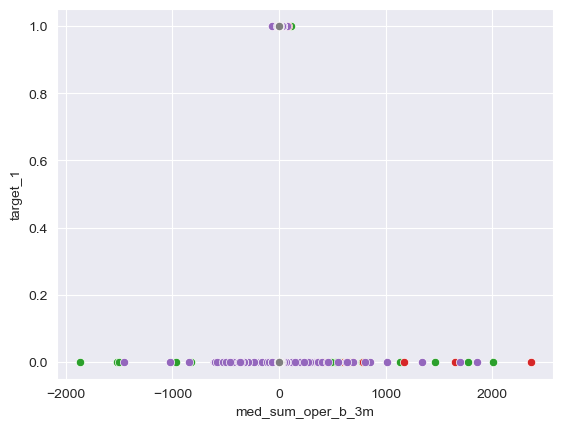

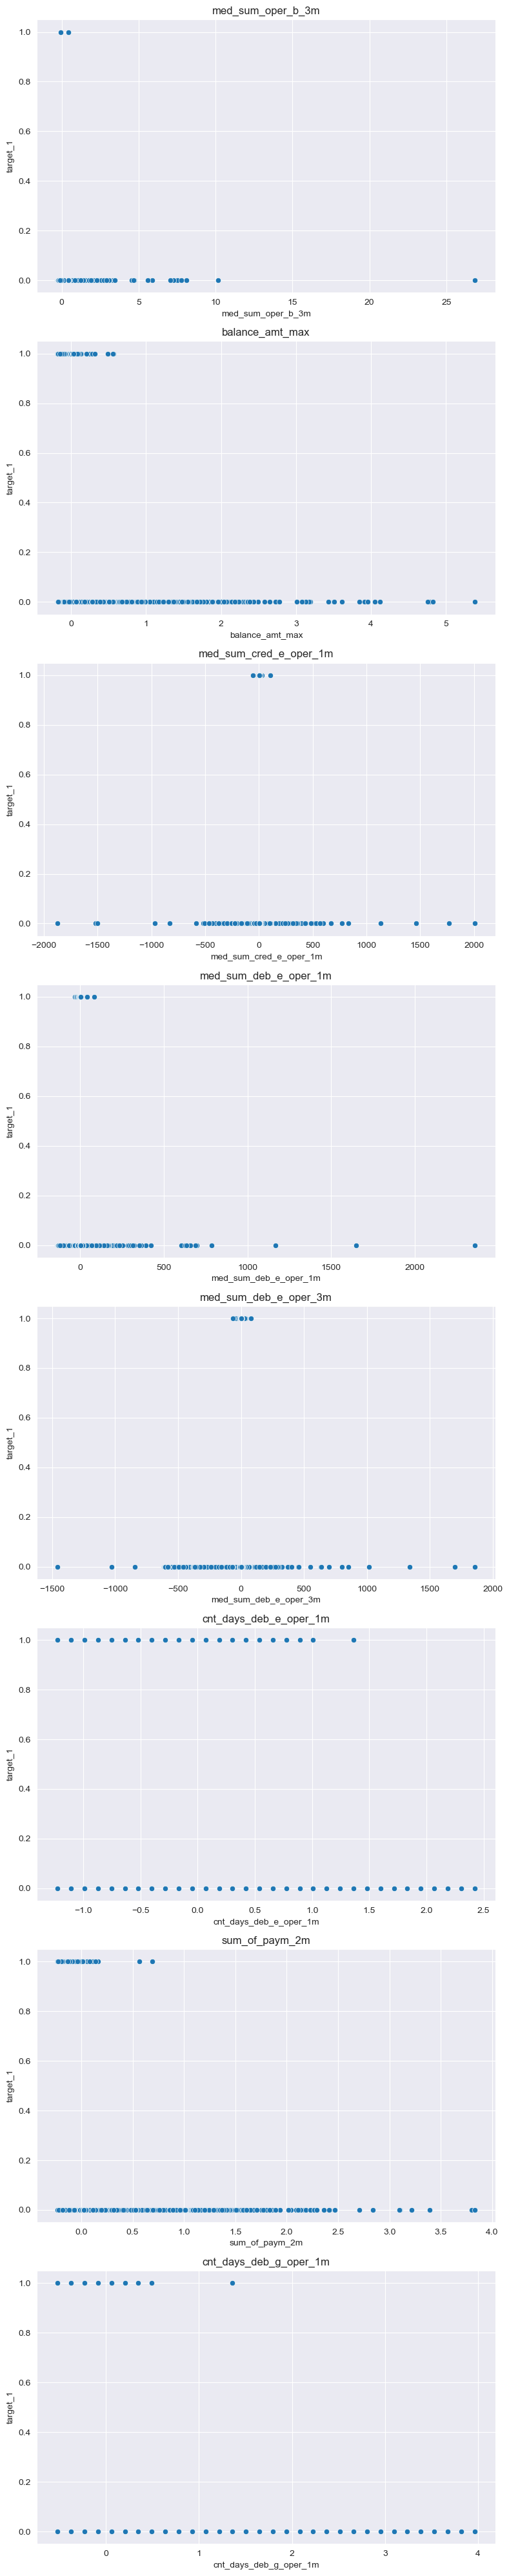

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns


for feature in important_features_1:
    sns.scatterplot(x=train_df[feature], y=target_1)

import matplotlib.pyplot as plt
import seaborn as sns

# Создайте общий график с несколькими подграфиками
fig, axes = plt.subplots(nrows=len(important_features_1), figsize=(8, 5 * len(important_features_1)))

# Итерируйтесь по признакам и стройте диаграммы рассеяния на соответствующих подграфиках
for i, feature in enumerate(important_features_1):
    sns.scatterplot(x=train_df[feature], y=target_1, ax=axes[i])
    axes[i].set_title(feature)

# Показать графики
plt.tight_layout()
plt.show()


### Обучение модели

In [30]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


x_train, x_val, y_train, y_val = train_test_split(X1_train, y1,
                                                  test_size=0.2,
                                                  random_state=42)

model = LGBMClassifier(verbosity=-1, random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict_proba(x_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9325839437793989

In [31]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


x_train, x_val, y_train, y_val = train_test_split(X2_train, y2,
                                                  test_size=0.2,
                                                  random_state=42)

model = LGBMClassifier(verbosity=-1, random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict_proba(x_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7881001603786582